<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/Hyundai/Outstanding_results_predicting_Apple_Stock_with_Continual_ML_using_Global_News_(with_Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

In this tutorial we’ll make a Machine Learning Pipeline that inputs Business News and generates predictions for Apple Stock Price re-training through time.
We’ll also measure how profitable it is in real life.

#What we’ll do
- Step 1: Set up technical prerequisites
- Step 2: Get the data for daily Apple Stock since 2017
- Step 3: Define and understand target for ML
- Step 4: Blend business news to our data
- Step 5: Prepare our data and apply ML
- Step 6: Measure and analyze results
- Step 7: Break the data and train/test through time

# Step 1. Prerequisites
- Have Python 2.6+ or 3.1+ installed
- Install pandas, sklearn and openblender (with pip)

In [1]:
!pip install pandas OpenBlender scikit-learn

     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 235kB 24.2MB/s 
  Created wheel for OpenBlender: filename=OpenBlender-1.16-cp36-none-any.whl size=5078 sha256=6434033ffbc77a8ad1aff31c19bed226d54b05017ae188f492619f86559f7a7a
  Stored in directory: /root/.cache/pip/wheels/1f/f4/97/72f35e6170517417d380e604194562cfdb1ccabee1953acc87
Successfully built OpenBlender


#Step 2. Get the data
We’ll use this daily Apple Stock dataset

https://www.openblender.io/#/dataset/explore/5d4c39d09516290b01c8307b/or/32

It has the daily high, low, open and close prices and the percentual change during that day.

So let’s pull the data through the OpenBlender API. Open a python script and run the following code:

In [3]:
# Import the libraries

import OpenBlender
import pandas as pd
import json

# Specify the action

action = 'API_getObservationsFromDataset'

# Specify your Token and 'Apple Inc. Price' id_dataset

parameters = { 
      'token':'5f572b699516297be2a397f2Jzf10HdnpuCCgrpPIt4DD38HE8PFA6',
      'id_dataset':'5d4c39d09516290b01c8307b',
      'date_filter':{"start_date":"2017-01-01T06:00:00.000Z",
                     "end_date":"2020-02-09T06:00:00.000Z"}
}
# Pull the data into a Pandas Dataframe
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)

Task ID: '5f572bfb0895fafb4a9d8d4b'.
Total estimated consumption: 22653.06 processing units.
Task confirmed. Starting download..
CSV will be stored in: 1599548411.7497697.csv
33.33 %
66.67 %
100.0 % completed.


Note: To get a token you need have to create an account on openblender.io (free ), you’ll find it in the ‘Account’ tab on your profile icon.

Now let’s look at the data:

In [4]:
df.head()

,volume,timestamp,price,high,low,open,change
0,29.42M,1581094800,320.03,323.40,318.18,322.38,-1.59%
1,26.36M,1581008400,325.21,325.21,320.35,323.06,1.17%
2,29.71M,1580922000,321.45,324.61,318.98,323.69,0.82%
3,34.15M,1580835600,318.85,319.64,313.70,315.86,3.30%
4,43.50M,1580749200,308.66,313.47,302.36,303.63,-0.27%


# Step 3. Define and understand Target

Let’s plot the price and Change :

In [6]:
from matplotlib import pyplot as plt


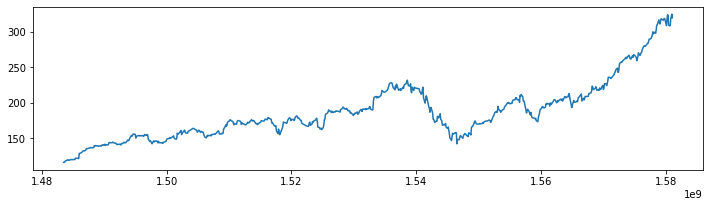

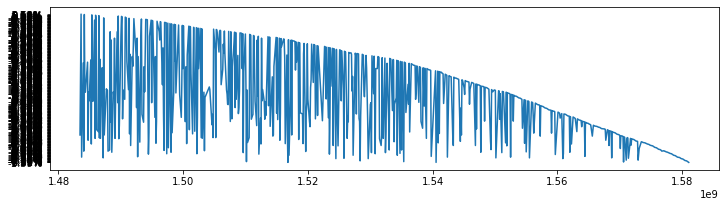

In [17]:
plt.figure(figsize=(12, 3))
plt.plot(df['timestamp'], df['price'])
plt.show()

plt.figure(figsize=(12, 3))
#plt.ylim(-10.0, 7.5)
plt.plot(df['timestamp'], df['change'])
plt.show()

Now, what we want is to detect if the price is going to increase or decrease on the next day so we can buy or short.

The ‘change’ is the percentual increase or decrease that happened between the opening and closing price, so it works for us.


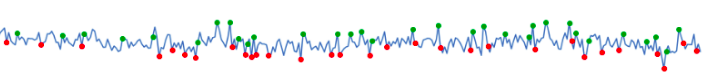

Let’s define our target variable as an increase larger than 0.5% (so that it’s wortwile to make a purchase):

Positive POC: Where ‘change’ increased more than 0.5%

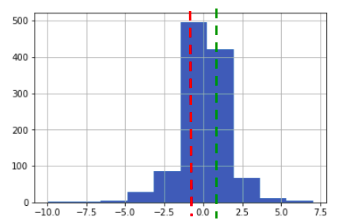

This means all the observations to the right side of the green line would be our ‘success’ scenarios.

#Step 4. Vectorize and Blend Business News

This is very simple to execute, but let’s try and understand what’s happening in the background.

What we want:

1. We need to gather usefull news data which conveniently (statistically speaking) relates to our target

2. We want to blend it to our data in a way that the news align whith the next day’s price ‘change’ (so the model can learn to predict for the next day and we can actually use it)
3. We want to transform it into numerical features so it can loop through an ML model.

So let’s look at this Wall Street Journal News dataset:
https://www.openblender.io/#/dataset/explore/5e2ef74e9516294390e810a9/or/32

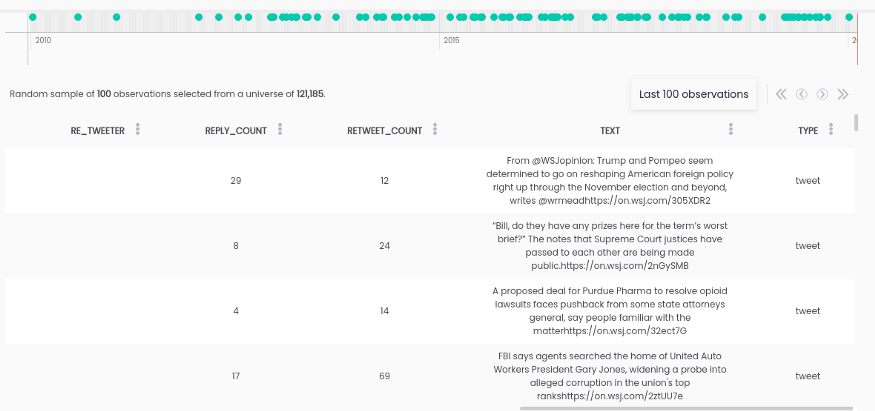

And the USA Today Twitter news.
https://www.openblender.io/#/dataset/explore/5e32fd289516291e346c1726/or/32

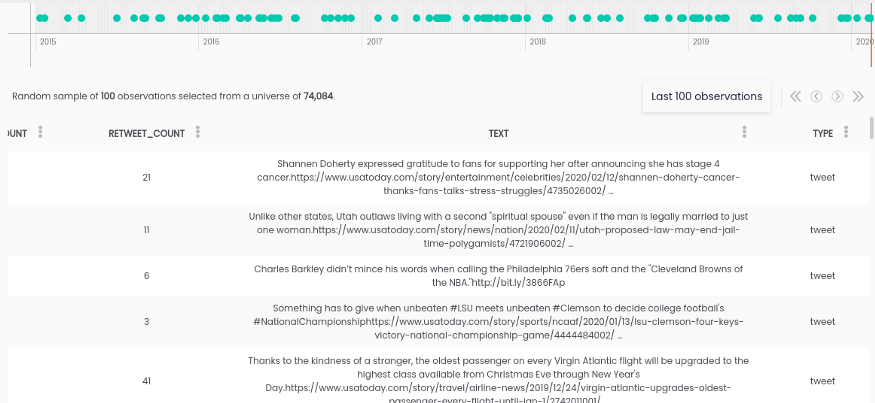

*Note: I picked these because they made sense, but you can search for hundreds of other ones.


Now let’s create a text vectorizer, which is a model on OpenBlender from which you can then pull vectorized words or groups of words as features, as if it were another dataset:

In [18]:
action = 'API_createTextVectorizerPlus'
parameters = {
    'token' : '5f572b699516297be2a397f2Jzf10HdnpuCCgrpPIt4DD38HE8PFA6',
    'name' : 'Wall Street and USA Today Vectorizer',
    'sources':[
              {'id_dataset':"5e2ef74e9516294390e810a9", 
               'features' : ["text"]},
              {'id_dataset' : "5e32fd289516291e346c1726", 
               'features' : ["text"]}
    ],
    'ngram_range' : {'min' : 1, 'max' : 2},
    'language' : 'en',
    'remove_stop_words' : 'on',
    'min_count_limit' : 2
}
response = OpenBlender.call(action, parameters)
response

{'id_textVectorizer': '5f57305c9516297be2a398a3',
 'num_ngrams': 4999,
 'response': 'Text Vectorizer created successfully.',
 'status': 'success'}

From above, we specified the following:

- name: We’ll name it ‘Wall Street and USA Today Vectorizer’

- sources: The ids and source columns of the datasets to include as source (in this case both with only one and both named ‘text’)

- ngram_range: The min and max length of the set of words which will be tokenized

- language: English

- remove_stop_words: So it eliminates stop-words from the source

- min_count_limit: The minimum of repetitions to be considered a token (one time occurrences rarely help)

Now, if we go to our dashboard at OpenBlender, we can see the vectorizer:

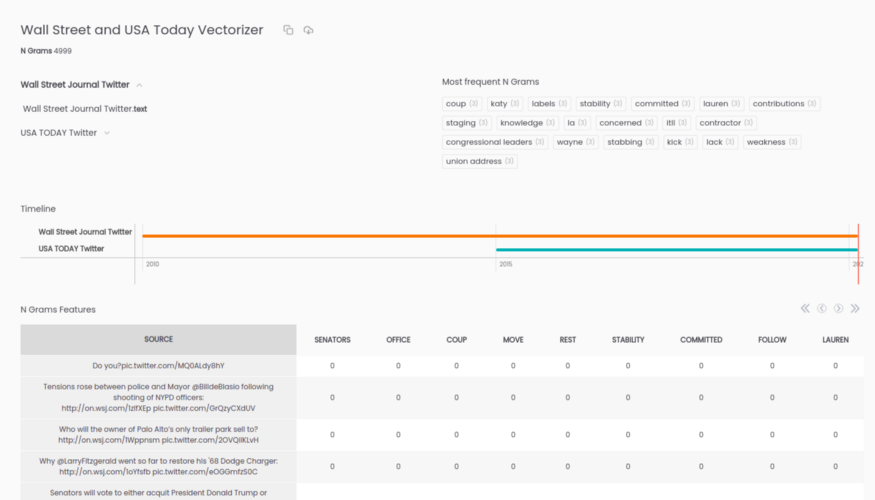

It generated 4999 n-grams which are binary features of tokens of max 2 words which are “1” if the n-gram was mentioned and “0” if else.

Now we want the vectorized data compressed in 24 hour time lags and aligned with the Apple stock price from the next day.

You need to add your vectorizer’s id (it was printed when you created it or you can get it in OpenBlender.

*Note: To download all the vectorized data you’ll need to pay about $6 USD by upgrading with the ‘Pay as you go’ option in OpenBlender. If you don’t upgrade you can still download a small part of the data reducing the date interval and continue.

In [20]:
action = 'API_getObservationsFromDataset'

interval = 60 * 60 * 24 # One day

parameters = { 
      'token':'5f572b699516297be2a397f2Jzf10HdnpuCCgrpPIt4DD38HE8PFA6',
      'id_dataset':'5d4c39d09516290b01c8307b',
      'date_filter':{"start_date":"2017-01-01T06:00:00.000Z",
                     "end_date":"2020-02-09T06:00:00.000Z"},
      'aggregate_in_time_interval' : {
              'time_interval_size' : interval, 
              'output' : 'avg', 
              'empty_intervals' : 'impute'
      },
      'blends' :
       [{"id_blend" : "5e46c8cf9516297ce1ada712",
         "blend_class" : "closest_observation", 
         "restriction":"None",
         "blend_type":"text_ts",
         "specifications":{"time_interval_size" : interval}
       }],
       'lag_feature' : {'feature' : 'change', 'periods' : [-1]}
}

df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)
['sample']), convert_dates=False, 
convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)

------------------------------------------------
API call error: There are not enough processing units to complete this task. Please upgrade your account or buy units in https://www.openblender.io/ at $0.0001 USD/unit.
------------------------------------------------

{"status": "internal error", "msg": "'bool' object is not subscriptable"}


TypeError: ignored

This is the same service call as before but with some new parameters:

- aggregate_in_time_interval: To aggregate the data by average in intervals of 24 hours and impute if there are intervals with no observations

- blends: Join the aggregated news 24 hour data by time

- lag_feature: We want the ‘change’ feature to be aligned with news that happened in the previous 24 hours

Let’s take a look at the top of the data (ordered by most recent):

In [ ]:
print(df.shape)
df.head()

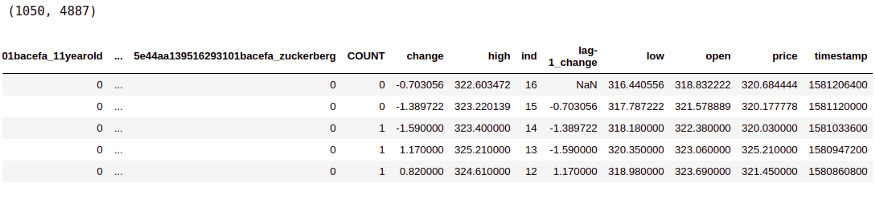

We have 1068 observations and 4887 features. Most of them are n-grams from the vectorizer, and we also have our original Apple Stock dataset.

And now we have the ‘lag-1_change’ feature which simply aligns the ‘change’ values with the “previous day data” which is exactly what we need. The most recent observations is NaN because that’s what we would want to predict for ‘tomorrow’.

#Step 5. Prepare the data and apply ML

There isn’t much more wrangling or cleansing to do, we just need to create our target features positive POC and negative POC (We’ll use ‘positive POC’ for our purpose as defined earlier).

In [21]:
# Where ‘change’ decreased more than 0.5%
df['negative_poc'] = [1 if val < 0.5 else 0 for val in df['lag-1_change']]

# Where ‘change’ increased more than 0.5%
df['positive_poc'] = [1 if val > 0.5 else 0 for val in df['lag-1_change']]

df[['lag-1_change', 'positive_poc', 'negative_poc']].head()

KeyError: ignored

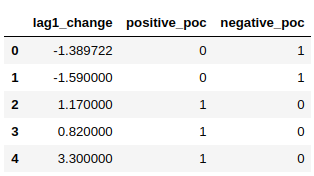

Now, let’s try some ML to learn and predict the positive poc.

In [ ]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
# Define target and remove unwanted features to avoid data leakage
target = 'positive_poc'
df_positive = df.select_dtypes(['number'])
for rem in ['lag-1_change', 'negative_poc']:
    df_positive = df_positive.loc[:, df_positive.columns != rem]
# Create train/test sets
X = df_positive.loc[:, df_positive.columns != target].values
y = df_positive.loc[:,[target]].values
# We take the first bit of the data as test and the last as train because the dataset is ordered by timestamp descending and we want to train with previous observations and test with subsequent ones.
div = int(round(len(X) * 0.29))

X_test = X[:div]
y_test = y[:div]

X_train = X[div:]
y_train = y[div:]
print('Train:')
print(X_train.shape)
print(y_train.shape)
print('Test:')
print(X_test.shape)
print(y_test.shape)

Now let’s train the model and predict:

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Step 6. Analyze the results
And now, for the results:

In [ ]:
print("AUC score:")
print(roc_auc_score(y_test, y_pred))
print('---')
# Let's binarize and look at the confusion matrix
preds = [1 if val > 0.5 else 0 for val in y_pred]
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, preds))
print('---')
# Lets look at the accuracy
print('Acurracy:')
print(accuracy_score(y_test, preds))
print('---')

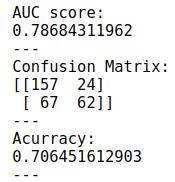

This is pretty amazing if I do say so myself.

Let’s analyze the results.

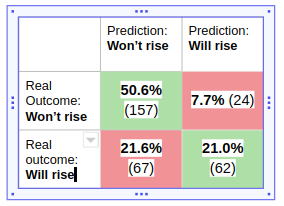

This means that from all the times this model predicted that the following day the price change would increase 0.5% or more, it was correct 72% of the times. I don’t know of any real life model that even compares to this.

If we ran the model at the end of one day, we could buy/short the following day in the morning expecting the result by the end of the day.

*Side note: If any of you run this into production for auto trading (or manual trading) at least send me a gift.

#Step 7. Break the data through time

Now, we want a methodology in which the data is trained and tested throgh time to see if the results are consistent.

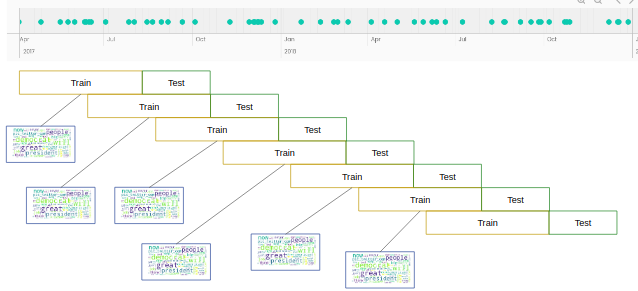

So let’s run what we just did but breaking data in thime in a loop.

In [ ]:
results = []
for i in range(0, 90, 5): 
 time_chunk = i/100
 print(“time_chunk:” + str(time_chunk) + “ starts”)
 df_ml = df_positive[:int(round(df_positive.shape[0] * (time_chunk + 0.4)))]
 X = df_ml.loc[:, df_ml.columns != target].values
 y = df_ml.loc[:,[target]].values
 div = int(round(len(X) * 0.29))
 X_test = X[:div]
 y_test = y[:div]
 X_train = X[div:]
 y_train = y[div:]
 rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
 rf.fit(X_train, y_train)
 y_pred = rf.predict(X_test)
 preds = [1 if val > threshold else 0 for val in y_pred]
 try:
 roc = roc_auc_score(y_test, y_pred)
 except:
 roc = 0
 conf_mat = metrics.confusion_matrix(y_test, preds)
 accuracy = accuracy_score(y_test, preds)
 results.append({
 ‘roc’ : roc,
 ‘accuracy’ : accuracy,
 ‘conf_mat’ : conf_mat,
 ‘time_chunk’ : time_chunk
 })

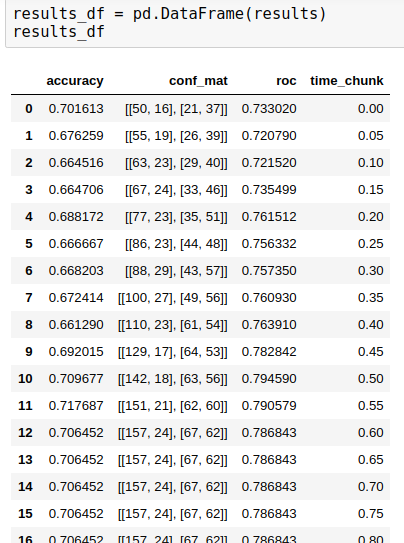

We can see the metrics increasing and stabilizing trough time!

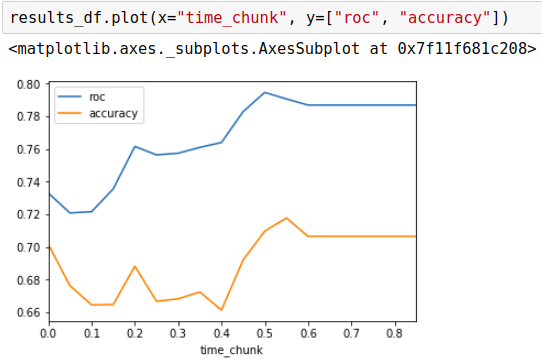

https://towardsdatascience.com/making-a-continual-ml-pipeline-to-predict-apple-stock-with-global-news-python-90e5d6610b21